# Fine-Grained Dog Breed Classification: A Deep Learning Approach

## Project Introduction

### What This Project Is About

This project tackles the problem of **fine-grained image classification** using **Convolutional Neural Networks (CNNs)**. Specifically, I will build a deep learning model to classify images of dogs into their specific breeds. This is a **multi-class classification problem** with 120 different dog breed categories.

The architecture approach will utilize **transfer learning with pre-trained CNN models** trained on ImageNet. I will implement and compare multiple architectures:

1. **Transfer Learning Approach**: Use pre-trained models (ResNet50 or EfficientNetB0) as feature extractors, freeze the convolutional base, and train only the new fully connected classification layers on the dog breed dataset
2. **Fine-Tuning Approach**: Start with pre-trained weights, then unfreeze some of the top convolutional layers and fine-tune them along with the classification layers using a low learning rate

I will compare these approaches to determine which strategy yields the best performance for this specific classification task.

### Goal and Motivation

**Goal**: To develop an accurate deep learning classifier that can identify dog breeds from images with high precision, and to understand which architectural approach works best for fine-grained visual recognition.

**Why This Matters**:

- **Practical Application**: Automated breed identification can help in animal shelters, veterinary clinics, and pet adoption services where quick and accurate breed identification is essential
- **Lost Pet Recovery**: Can assist in matching found dogs with lost pet reports
- **Education**: Helps dog enthusiasts and potential pet owners learn about different breeds
- **Technical Challenge**: Dog breed classification is a challenging fine-grained visual recognition problem because many breeds share similar physical characteristics (facial features, body shape, coat patterns), making it an excellent testbed for evaluating deep learning techniques and transfer learning strategies

**What I Want to Achieve**:

- Build a model that can accurately distinguish between 120 dog breeds, even when breeds look visually similar (e.g., Siberian Husky vs. Alaskan Malamute)
- Compare the effectiveness of transfer learning versus training from scratch
- Understand which visual features the model uses to make distinctions through visualization techniques (such as class activation maps)
- Achieve practical accuracy that could be deployed in real-world applications

_______

**Expected Outcomes**: A trained CNN model with >80% accuracy on the test set, comprehensive comparison of different architectures, and insights into what makes certain breeds easier or harder to classify.

### Hardware Requirements & Cost Considerations

Deep learning for image classification is **compute-intensive** and requires GPU acceleration for practical training times.

#### Hardware Requirements

**GPU (Essential)**:

- **Minimum**: NVIDIA GPU with 8GB+ VRAM
- **Recommended**: 16GB+ VRAM (A40, A100, RTX 3090/4090)
- Training on CPU would take 50-100× longer (days instead of hours)

#### Training Costs (RunPod Cloud GPU)

**Current Setup**: 1× NVIDIA A40 (46GB) at $0.41/hour

| Training Stage | Time | Cost |
|----------------|------|------|
| Single model training | 1-2 hours | $0.41-0.82 |
| Full experimental pipeline | 1-2 days | $10-20 |

## Data Loading & Initial Inspection

### Dataset: Stanford Dogs

**Source**: Stanford Dogs Dataset [@khosla2011novel]  
**URL**: http://vision.stanford.edu/aditya86/ImageNetDogs/  
**License**: Academic/Research use  
**Size**: ~750MB (images), 20,580 total images

**Dataset Description**:

The Stanford Dogs dataset [@khosla2011novel] contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization.

**Key Statistics**:

- **120 dog breed classes** (Chihuahua, Afghan_hound, Maltese_dog, Golden_retriever, etc.)
- **20,580 images total** (after validation)
- **Average 171.5 images per breed** (range: 148-252)
- **Average image dimensions**: 443×386 pixels
- **Image format**: JPEG (20,579 images), PNG (1 image)
- **Color mode**: RGB (20,579 images), RGBA (1 image)

**Data Organization**:

Images are organized in directories by breed:
```
data/raw/Images/
|-- n02085620-Chihuahua/
|-- n02085782-Japanese_spaniel/
|-- n02085936-Maltese_dog/
+-- ... (120 breed directories total)
```

**Preprocessing Pipeline**:

1. **Download** (`python -m dbc.ingest`): Downloaded images, annotations, and breed mapping
2. **Validation** (`python -m dbc.preprocess`): Scanned all 20,580 images, validated for corruption, size, and format
3. **Cleaning**: Removed 0 corrupt images, all images passed validation
4. **Splitting**: Created stratified 80/20 train/validation split
   - Train: 16,508 images
   - Validation: 4,072 images

**Why This Dataset?**:

- **Fine-grained classification challenge**: Many breeds share similar visual features, making this an excellent test for CNN architectures
- **Sufficient data**: ~170 images per class enables meaningful training with data augmentation
- **Real-world applicability**: Breed identification has practical uses in animal shelters, veterinary clinics, and pet services

**Dataset Challenges**:

This dataset presents several real-world complications that make classification more challenging:

- **Multiple Objects**: Many images contain humans, other animals, or various background objects alongside the dogs
- **Variable Composition**: Dogs may occupy only a small portion of the image frame
- **Background Clutter**: Complex backgrounds with furniture, outdoor scenery, or other distractions
- **Occlusion**: Dogs may be partially hidden or cropped in some images

These challenges make the task more realistic and require the model to learn discriminative breed features despite visual noise.

In [18]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import json

# Load breed mapping
breeds_df = pd.read_csv("../data/raw/breed_mapping.csv")
print("Breed Mapping (first 10 breeds):")
display(breeds_df.head(10))

# Load train/val metadata
train_df = pd.read_csv("../artifacts/train_metadata.csv")
val_df = pd.read_csv("../artifacts/val_metadata.csv")

print(f"\nTrain set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")

# Load dataset statistics
with open("../artifacts/dataset_stats.json", "r") as f:
    stats = json.load(f)
    
print("\nDataset Statistics:")
for key, value in stats.items():
    if key not in ['image_modes', 'image_formats']:
        print(f"  {key}: {value}")
        
print("\nTrain metadata (first 5 samples):")
display(train_df[['breed_name', 'class_id', 'width', 'height', 'filename']].head())

Breed Mapping (first 10 breeds):


class_id           breed_name                      breed_dir
0         1            Chihuahua            n02085620-Chihuahua
1         2     Japanese_spaniel     n02085782-Japanese_spaniel
2         3          Maltese_dog          n02085936-Maltese_dog
3         4             Pekinese             n02086079-Pekinese
4         5             Shih-Tzu             n02086240-Shih-Tzu
5         6     Blenheim_spaniel     n02086646-Blenheim_spaniel
6         7             papillon             n02086910-papillon
7         8          toy_terrier          n02087046-toy_terrier
8         9  Rhodesian_ridgeback  n02087394-Rhodesian_ridgeback
9        10         Afghan_hound         n02088094-Afghan_hound


Train set: 16508 images
Validation set: 4072 images

Dataset Statistics:
  total_images: 20580
  total_breeds: 120
  avg_images_per_breed: 171.5
  min_images_per_breed: 148
  max_images_per_breed: 252
  avg_width: 442.5318756073858
  avg_height: 385.8612244897959
  avg_size_kb: 36.90375502042335

Train metadata (first 5 samples):


breed_name  class_id  width  height            filename
0  Afghan_hound        10    489     500   n02088094_294.jpg
1  Afghan_hound        10    500     375   n02088094_173.jpg
2  Afghan_hound        10    459     500  n02088094_4635.jpg
3  Afghan_hound        10    340     500   n02088094_515.jpg
4  Afghan_hound        10    500     333  n02088094_4072.jpg

## Preprocess

### Data Cleaning

Before training our CNN model, we need to ensure our dataset is clean and ready. This section analyzes the raw scanned data and applies quality filters to remove problematic images.

**Cleaning Checks Performed:**

1. **Corrupt Image Detection** - Identify images that cannot be loaded or have invalid pixel data
2. **Duplicate Removal** - Find and remove duplicate filenames to prevent data leakage
3. **Size Validation** - Filter out images that are too small (<50×50px) or too large (>10MB)
4. **Color Mode Analysis** - Check for grayscale/RGBA images that need RGB conversion
5. **Aspect Ratio Check** - Flag extreme aspect ratios that may cause issues during resizing

**Why This Matters:**

- **Prevents training crashes** - Ensures all images can be loaded successfully
- **Improves data quality** - Removes low-quality or problematic images
- **Avoids data leakage** - Duplicate removal prevents the same image appearing in train and validation
- **Informs preprocessing** - Understanding color modes and aspect ratios helps design the data pipeline

In [19]:
# Load the raw scan results to show cleaning process
scan_df = pd.read_csv("../artifacts/dataset_scan.csv")

print("Data Cleaning Pipeline")
print("="*60)

# Step 1: Check for invalid/corrupt images
invalid_images = scan_df[scan_df['valid'] == False]
print(f"\n1. Invalid/Corrupt Images: {len(invalid_images)}")
if len(invalid_images) > 0:
    print("   Errors found:")
    for _, row in invalid_images.head(5).iterrows():
        print(f"     - {row['filename']}: {row['error']}")
else:
    print("   ✓ No corrupt images detected")

# Step 2: Check for duplicates
duplicates = scan_df[scan_df.duplicated(subset=['filename'], keep=False)]
print(f"\n2. Duplicate Files: {len(duplicates)}")
if len(duplicates) > 0:
    print(f"   Found {len(duplicates)} duplicate filenames")
else:
    print("   ✓ No duplicates found")

# Step 3: Size violations
size_violations = scan_df[
    (scan_df['width'] < 50) | 
    (scan_df['height'] < 50) | 
    (scan_df['size_kb'] > 10000)
]
print(f"\n3. Size Violations: {len(size_violations)}")
print(f"   - Too small (<50px): {len(scan_df[(scan_df['width'] < 50) | (scan_df['height'] < 50)])}")
print(f"   - Too large (>10MB): {len(scan_df[scan_df['size_kb'] > 10000])}")
if len(size_violations) == 0:
    print("   ✓ All images meet size requirements")

# Step 4: Color mode check
print(f"\n4. Color Modes:")
color_modes = scan_df['mode'].value_counts()
for mode, count in color_modes.items():
    print(f"   - {mode}: {count} images")
non_rgb = scan_df[scan_df['mode'] != 'RGB']
print(f"   Note: {len(non_rgb)} non-RGB images will be converted during training")

Data Cleaning Pipeline

1. Invalid/Corrupt Images: 0
   ✓ No corrupt images detected

2. Duplicate Files: 0
   ✓ No duplicates found

3. Size Violations: 0
   - Too small (<50px): 0
   - Too large (>10MB): 0
   ✓ All images meet size requirements

4. Color Modes:
   - RGB: 20579 images
   - RGBA: 1 images
   Note: 1 non-RGB images will be converted during training


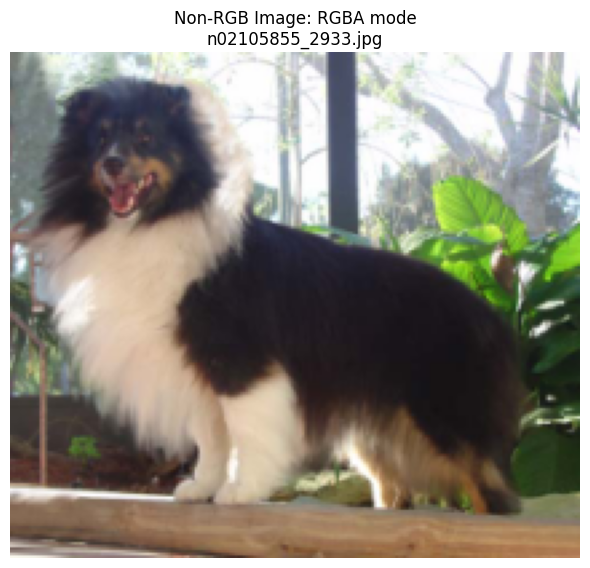


   Decision: The 1 RGBA image will be automatically converted to RGB
   during data loading (see data_loader.py). No manual fixing needed.
   This is better than modifying raw data files.


In [20]:
# Show the one non-RGB image
if len(non_rgb) > 0:
    img_path = Path("..") / non_rgb.iloc[0]['absolute_path']
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Non-RGB Image: {non_rgb.iloc[0]['mode']} mode\n{non_rgb.iloc[0]['filename']}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n   Decision: The 1 RGBA image will be automatically converted to RGB")
    print(f"   during data loading (see data_loader.py). No manual fixing needed.")
    print(f"   This is better than modifying raw data files.")

In [21]:
# Step 5: Extreme aspect ratios
scan_df['aspect_ratio'] = scan_df['width'] / scan_df['height']
extreme_ratios = scan_df[
    (scan_df['aspect_ratio'] < 0.2) | 
    (scan_df['aspect_ratio'] > 5.0)
]
print(f"\n5. Extreme Aspect Ratios (<0.2 or >5.0): {len(extreme_ratios)}")
if len(extreme_ratios) > 0:
    print("   Images with unusual ratios (may need special handling):")
    for _, row in extreme_ratios.head(3).iterrows():
        print(f"     - {row['filename']}: {row['aspect_ratio']:.2f}")

# Final summary
print("\n" + "="*60)
print("CLEANING SUMMARY")
print("="*60)
clean_count = len(scan_df[scan_df['valid'] == True])
removed = len(scan_df) - clean_count
print(f"Initial images:    {len(scan_df)}")
print(f"Removed:           {removed}")
print(f"Clean images:      {clean_count}")
print(f"Removal rate:      {removed/len(scan_df)*100:.2f}%")
print("\n✓ Dataset is clean and ready for training!")


5. Extreme Aspect Ratios (<0.2 or >5.0): 0

CLEANING SUMMARY
Initial images:    20580
Removed:           0
Clean images:      20580
Removal rate:      0.00%

✓ Dataset is clean and ready for training!


### Cleaning Results Summary

**Perfect Dataset Quality** - All 20,580 images passed validation with zero issues:

- **0 corrupt images** - All files load successfully
- **0 duplicates** - No data leakage risk  
- **0 size violations** - All images meet dimension and file size requirements
- **1 RGBA image** - Will be auto-converted to RGB during loading

**Label Indexing Fix Applied**:

The breed mapping assigns `class_id` values from 1-120 (human-readable format), but Keras neural networks require 0-indexed labels (0-119). This is handled automatically in the data loading pipeline:

- **Source data**: `breed_mapping.csv` has `class_id` = 1-120
- **Training pipeline**: `data_loader.py` subtracts 1 to convert to 0-119
- **Implementation**: See `data_loader.py:106` - `return img_array, row['class_id'] - 1, breed_name`

This ensures compatibility with Keras while keeping human-readable breed mappings in the raw data.

**Conclusion:** The dataset is exceptionally clean and ready for the data loading pipeline.

## Exploratory Data Analysis

In this section, we explore the dataset characteristics to understand:

1. **Sample images**: Visual inspection of different breeds
2. **Class distribution**: How balanced are the 120 breed classes?
3. **Image dimensions**: Variation in image sizes and aspect ratios
4. **Data quality**: Any patterns or issues to address before training

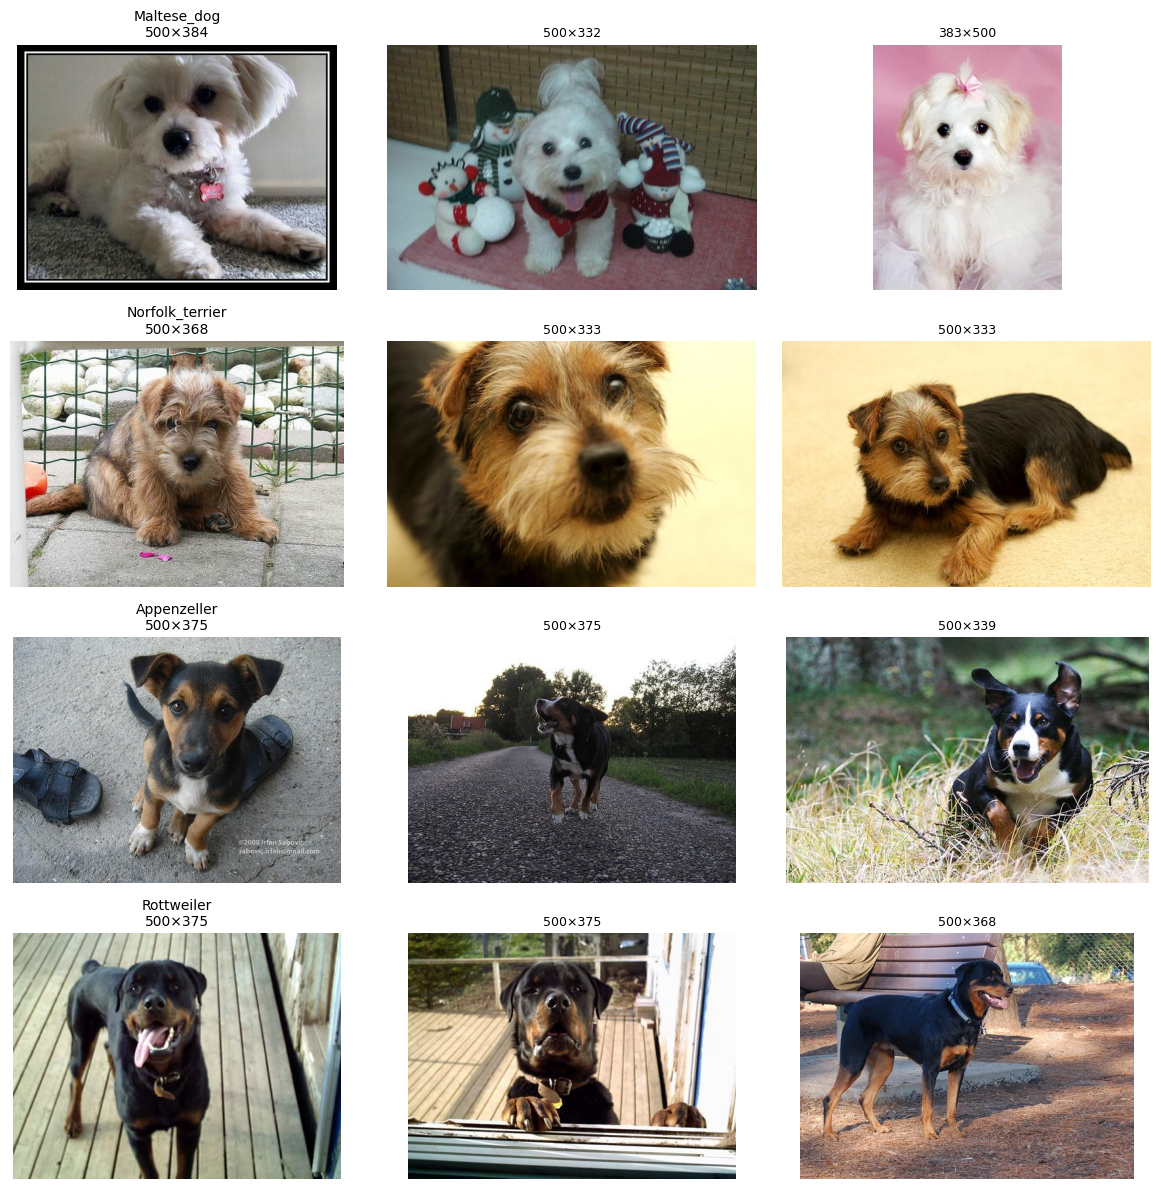

In [22]:
# Visualize sample images from different breeds
def show_sample_images(train_df, n_breeds=4, images_per_breed=3):
    """Display sample images from random breeds"""
    
    # Sample random breeds
    breeds = train_df['breed_name'].unique()
    sample_breeds = np.random.choice(breeds, 
                                     size=min(n_breeds, len(breeds)), replace=False)
    
    fig, axes = plt.subplots(n_breeds, images_per_breed, figsize=(12, n_breeds*3))
    
    for i, breed in enumerate(sample_breeds):
        breed_images = train_df[train_df['breed_name'] 
                                == breed].sample(n=images_per_breed)
        
        for j, (_, row) in enumerate(breed_images.iterrows()):
            # Use absolute_path which has full path from project root
            img_path = Path("..") / "data" / "raw" / row['file_path']
            img = Image.open(img_path)
            
            ax = axes[i, j] if n_breeds > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:
                ax.set_title(f"{breed}\n{img.size[0]}×{img.size[1]}", fontsize=10)
            else:
                ax.set_title(f"{img.size[0]}×{img.size[1]}", fontsize=9)
    
    plt.tight_layout()
    plt.savefig("../artifacts/figures/sample_images.png", 
                dpi=150, bbox_inches='tight')
    plt.show()

# Create figures directory
Path("../artifacts/figures").mkdir(parents=True, exist_ok=True)

# Show samples
np.random.seed(42)
show_sample_images(train_df, n_breeds=4, images_per_breed=3)


Sample images showing variety in:

- Breed appearance (different sizes, coat colors, facial features)
- Image dimensions (various aspect ratios and resolutions)
- Photography conditions (backgrounds, lighting, angles)

### Image Dimension Analysis

Understanding image sizes helps us choose appropriate preprocessing strategies

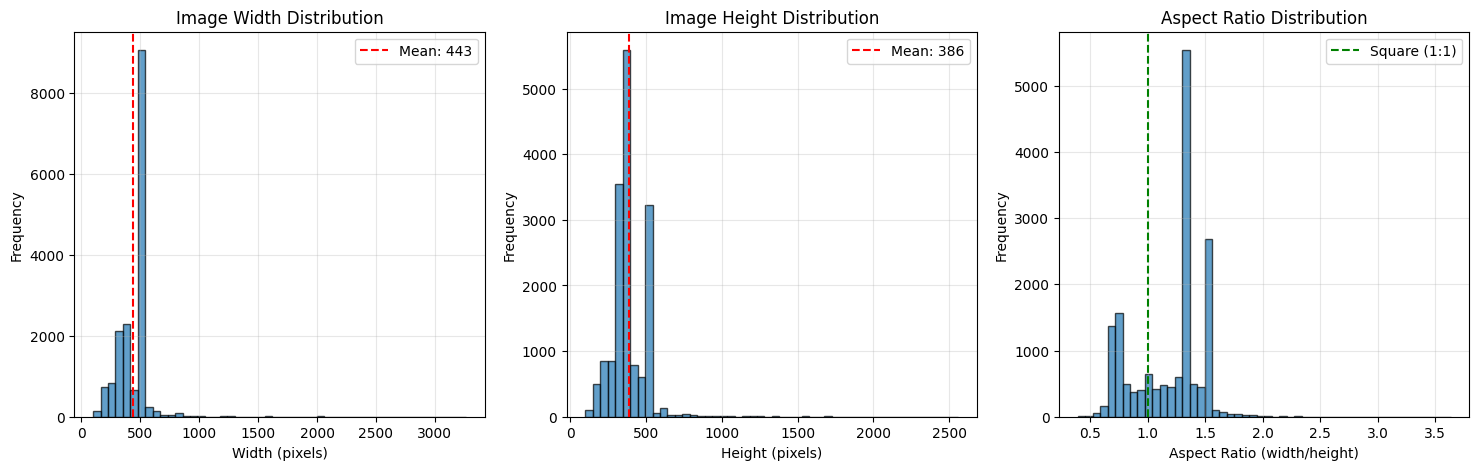

In [23]:
# Analyze image dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Width distribution
axes[0].hist(train_df['width'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(train_df['width'].mean(), color='red', linestyle='--',
                   label=f'Mean: {train_df["width"].mean():.0f}')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Height distribution
axes[1].hist(train_df['height'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(train_df['height'].mean(), color='red', linestyle='--',
                   label=f'Mean: {train_df["height"].mean():.0f}')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Aspect ratio
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
axes[2].hist(train_df['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(1.0, color='green', linestyle='--', label='Square (1:1)')
axes[2].set_xlabel('Aspect Ratio (width/height)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].legend()
axes[2].grid(alpha=0.3)

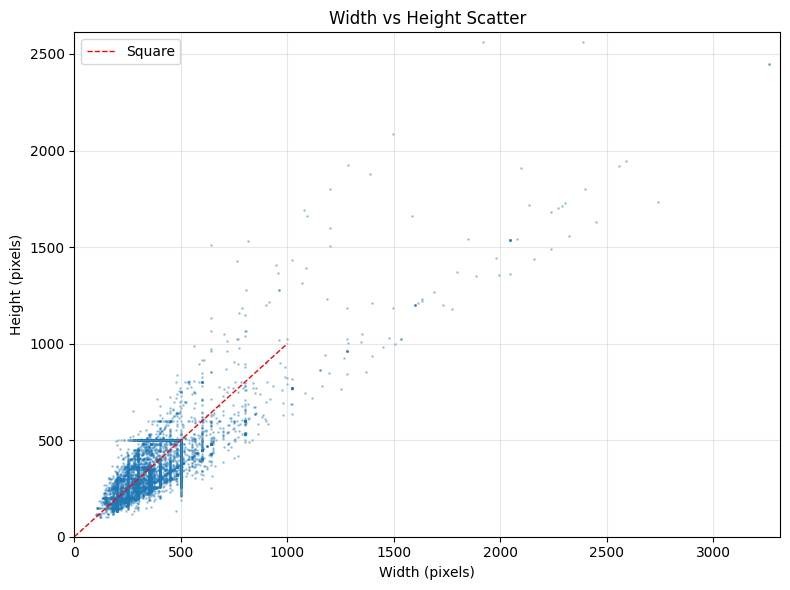

In [24]:
# Scatter: width vs height
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(train_df['width'], train_df['height'], alpha=0.3, s=1)
ax.plot([0, 1000], [0, 1000], 'r--', label='Square', linewidth=1)
ax.set_xlabel('Width (pixels)')
ax.set_ylabel('Height (pixels)')
ax.set_title('Width vs Height Scatter')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, train_df['width'].max() + 50)
ax.set_ylim(0, train_df['height'].max() + 50)

plt.tight_layout()
plt.savefig("../artifacts/figures/image_dimensions_scatter.png", 
            dpi=150, bbox_inches='tight')
plt.show()

**Key Findings:**

**Highly Variable Dimensions**: Images range from 100×100 to 3264×2562 pixels with mean 443×386

- **Width**: Mean 443px (±145), Range [100, 3264]
- **Height**: Mean 386px (±127), Range [100, 2562]  
- **Aspect Ratio**: Mean 1.19 (±0.30), mostly landscape orientation

**Low-Resolution Images**: Some images will require upscaling

- Resizing 100×100 → 224×224 requires 2.2× upscaling (will be blurry)
- Most images (mean ~440×390) will be downscaled, preserving quality
- Low-res images may be harder for the model to classify accurately

**Preprocessing Decision**: Resizing to 224×224 is appropriate since:

- Most images are already close to this size (reduces distortion)
- Standard for ImageNet pre-trained models (ResNet, VGG, EfficientNet)
- Square format normalizes the varying aspect ratios
- Bilinear interpolation handles both upscaling and downscaling

Let us also take a look at the low-resolution images that need upscaling:

In [25]:
# Analyze low-resolution images needing upscaling
print("Low-Resolution Image Analysis")
print("="*60)

# Images smaller than target size (224x224)
needs_upscale = train_df[
    (train_df['width'] < 224) | (train_df['height'] < 224)
]
n_total = len(train_df)
n_small = len(needs_upscale)
pct_small = n_small / n_total * 100

print(f"\nImages requiring upscaling: {n_small} / {n_total}")
print(f"  Percentage: {pct_small:.1f}%")

# Break down by severity
very_small = train_df[
    (train_df['width'] < 150) & (train_df['height'] < 150)
]
small = train_df[
    ((train_df['width'] >= 150) & (train_df['width'] < 224)) |
    ((train_df['height'] >= 150) & (train_df['height'] < 224))
]

n_very_small = len(very_small)
n_sm = len(small)
print(f"  - Very small (<150×150): {n_very_small} images")
print(f"     ({n_very_small/n_total*100:.2f}%)")
print(f"  - Small (150-224): {n_sm} images")
print(f"     ({n_sm/n_total*100:.2f}%)")

Low-Resolution Image Analysis

Images requiring upscaling: 1261 / 16508
  Percentage: 7.6%
  - Very small (<150×150): 15 images
     (0.09%)
  - Small (150-224): 1233 images
     (7.47%)



Smallest images:
  n02089078_4466.jpg: 100×115 - black-and-tan_coonhound
  n02110627_13453.jpg: 103×120 - affenpinscher
  n02089973_2943.jpg: 106×150 - English_foxhound
  n02089973_243.jpg: 107×150 - English_foxhound
  n02101388_4333.jpg: 108×120 - Brittany_spaniel


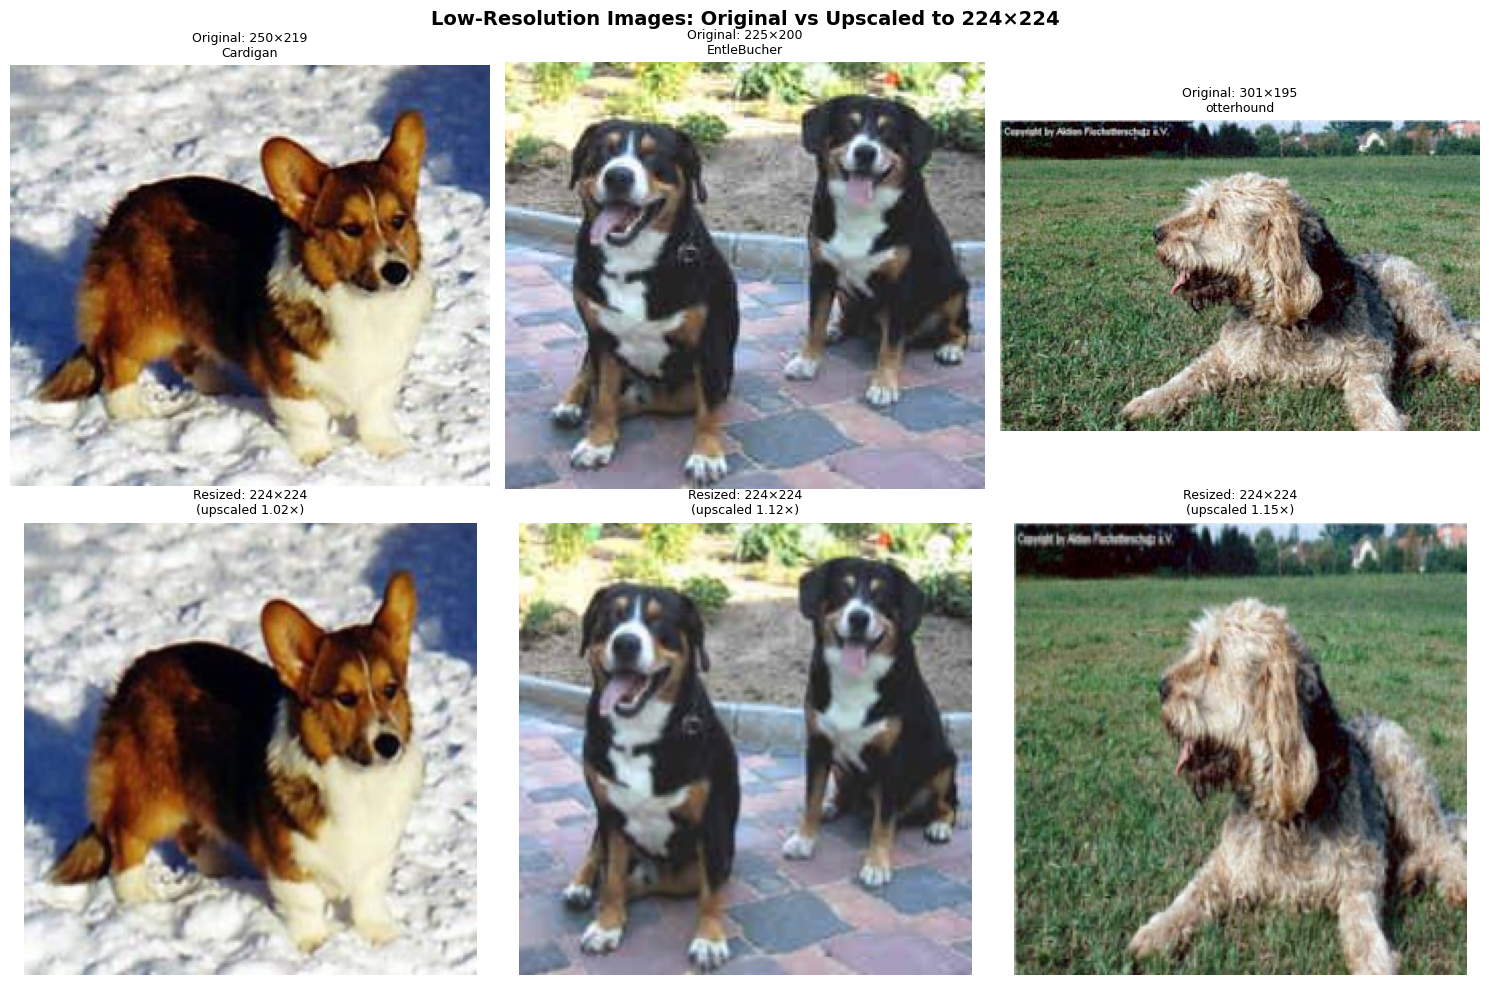


✓ Conclusion: Despite 7.6% of images
  requiring upscaling, bilinear interpolation
  preserves key visual features (breed characteristics,
  coat patterns, facial structure) sufficiently well
  for classification. Upscaling quality is acceptable.


In [26]:
# Find the smallest images
print(f"\nSmallest images:")
smallest = train_df.nsmallest(5, ['width', 'height'])
for _, row in smallest.iterrows():
    fname = row['filename']
    w, h = row['width'], row['height']
    breed = row['breed_name']
    print(f"  {fname}: {w}×{h} - {breed}")

# Visualize upscaling effect on small images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Show 3 small images: original vs resized
sample_imgs = needs_upscale.sample(
    n=min(3, len(needs_upscale)), 
    random_state=42
)

for i, (_, row) in enumerate(sample_imgs.iterrows()):
    img_path = Path("..") / "data" / "raw" / row['file_path']
    img_orig = Image.open(img_path).convert('RGB')
    img_resized = img_orig.resize((224, 224), Image.BILINEAR)
    
    # Original
    axes[0, i].imshow(img_orig)
    w, h = img_orig.size
    breed = row['breed_name']
    title_orig = f"Original: {w}×{h}\n{breed}"
    axes[0, i].set_title(title_orig, fontsize=9)
    axes[0, i].axis('off')
    
    # Resized
    axes[1, i].imshow(img_resized)
    scale_factor = 224 / min(img_orig.size)
    title_resized = f"Resized: 224×224\n(upscaled {scale_factor:.2f}×)"
    axes[1, i].set_title(title_resized, fontsize=9)
    axes[1, i].axis('off')

suptitle = "Low-Resolution Images: Original vs Upscaled to 224×224"
plt.suptitle(suptitle, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../artifacts/figures/upscaling_comparison.png", 
            dpi=150, bbox_inches='tight')
plt.show()

pct_upscale = n_small / n_total * 100
print(f"\n✓ Conclusion: Despite {pct_upscale:.1f}% of images")
print(f"  requiring upscaling, bilinear interpolation")
print(f"  preserves key visual features (breed characteristics,")
print(f"  coat patterns, facial structure) sufficiently well")
print(f"  for classification. Upscaling quality is acceptable.")

### Class Distribution Analysis

Understanding how balanced our dataset is across the 120 dog breeds helps us anticipate potential model bias and decide if techniques like class weighting are needed.


Class Balance Analysis:
  Total breeds: 120
  Min images per breed: 119
  Max images per breed: 202
  Mean images per breed: 137.6
  Std images per breed: 18.6
  Imbalance ratio (max/min): 1.70x

Most common breeds:
  Maltese_dog: 202 images
  Afghan_hound: 192 images
  Scottish_deerhound: 186 images
  Pomeranian: 176 images
  Samoyed: 175 images

Least common breeds:
  clumber: 120 images
  Border_collie: 120 images
  Pekinese: 120 images
  Bouvier_des_Flandres: 120 images
  redbone: 119 images


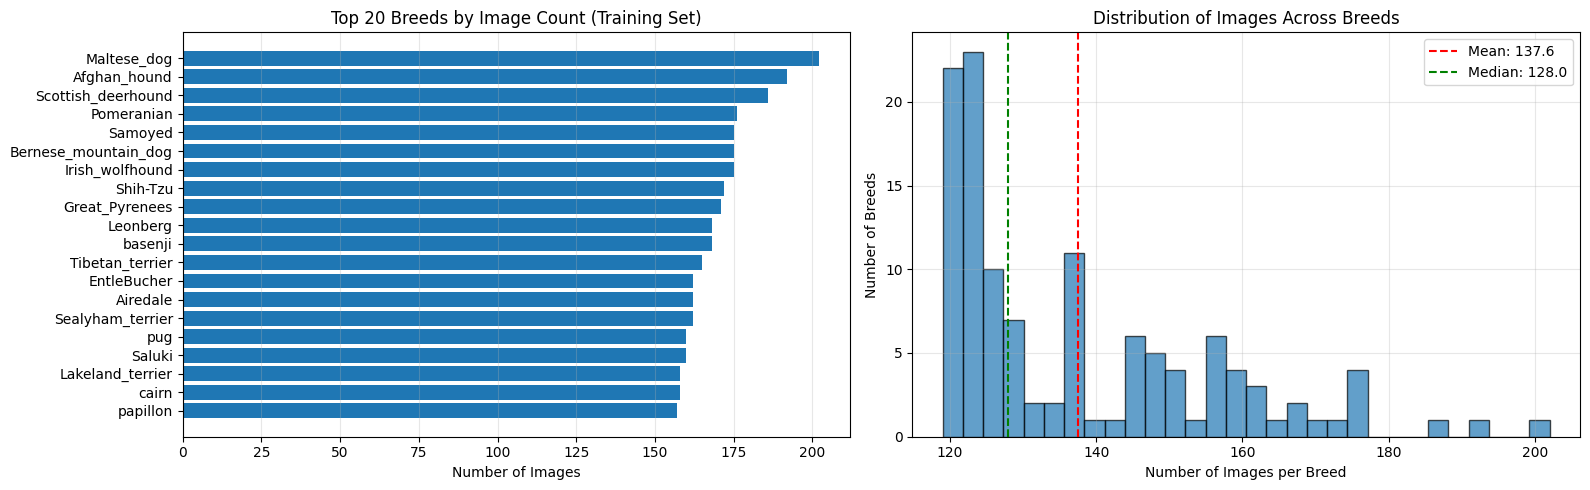

In [27]:
# Analyze class distribution
breed_counts = train_df['breed_name'].value_counts()
breed_counts = breed_counts.sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Top 20 breeds
top20 = breed_counts.head(20)
axes[0].barh(top20.index[::-1], top20.values[::-1])
axes[0].set_xlabel('Number of Images')
axes[0].set_title('Top 20 Breeds by Image Count (Training Set)')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Distribution histogram
axes[1].hist(breed_counts.values, bins=30, 
             edgecolor='black', alpha=0.7)

mean_val = breed_counts.mean()
median_val = breed_counts.median()
axes[1].axvline(mean_val, color='red', linestyle='--',
                label=f'Mean: {mean_val:.1f}')
axes[1].axvline(median_val, color='green', linestyle='--',
                label=f'Median: {median_val:.1f}')
axes[1].set_xlabel('Number of Images per Breed')
axes[1].set_ylabel('Number of Breeds')
axes[1].set_title('Distribution of Images Across Breeds')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../artifacts/figures/breed_distribution.png", 
            dpi=150, bbox_inches='tight')

print(f"\nClass Balance Analysis:")
print(f"  Total breeds: {len(breed_counts)}")
print(f"  Min images per breed: {breed_counts.min()}")
print(f"  Max images per breed: {breed_counts.max()}")
print(f"  Mean images per breed: {mean_val:.1f}")
print(f"  Std images per breed: {breed_counts.std():.1f}")

imbalance_ratio = breed_counts.max() / breed_counts.min()
print(f"  Imbalance ratio (max/min): {imbalance_ratio:.2f}x")

print(f"\nMost common breeds:")
for breed, count in breed_counts.head(5).items():
    print(f"  {breed}: {count} images")
    
print(f"\nLeast common breeds:")
for breed, count in breed_counts.tail(5).items():
    print(f"  {breed}: {count} images")


Sample Adequacy Summary:
  Breeds with <130 samples (may underperform): 62
  Breeds with 130-150 samples (adequate): 28
  Breeds with >150 samples (good): 30

Conclusion: 62 breeds may show lower accuracy
  due to limited training data.


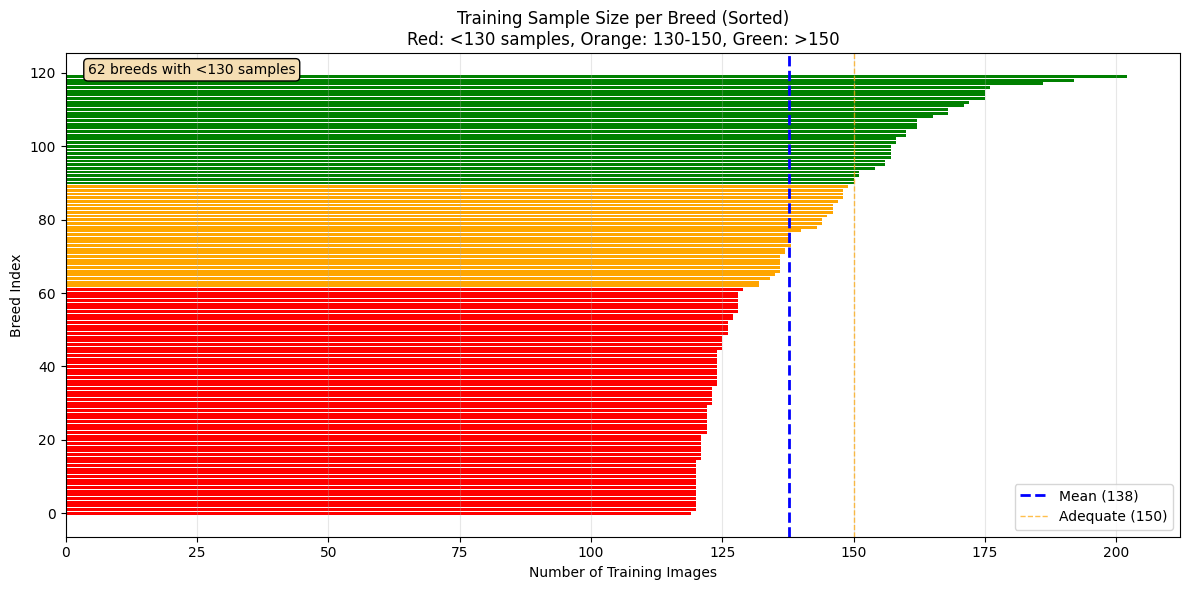

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

breed_counts_sorted = breed_counts.sort_values(ascending=True)
colors = [
    'red' if x < 130 else 'orange' if x < 150 else 'green'
    for x in breed_counts_sorted.values
]

ax.barh(range(len(breed_counts_sorted)), 
        breed_counts_sorted.values, color=colors)
ax.axvline(137.6, color='blue', linestyle='--', 
           linewidth=2, label='Mean (138)')
ax.axvline(150, color='orange', linestyle='--', 
           linewidth=1, alpha=0.7, label='Adequate (150)')

ax.set_xlabel('Number of Training Images')
ax.set_ylabel('Breed Index')
title = ('Training Sample Size per Breed (Sorted)\n'
         'Red: <130 samples, Orange: 130-150, Green: >150')
ax.set_title(title)
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add text annotation
n_low = (breed_counts < 130).sum()
annotation_text = f'{n_low} breeds with <130 samples'
bbox_style = dict(boxstyle='round', facecolor='wheat')
ax.text(0.02, 0.98, annotation_text, transform=ax.transAxes, 
        va='top', bbox=bbox_style)

plt.tight_layout()
plt.savefig("../artifacts/figures/sample_adequacy.png", 
            dpi=150, bbox_inches='tight')

# Calculate breed counts by category
n_low = (breed_counts < 130).sum()
n_adequate = ((breed_counts >= 130) & 
              (breed_counts < 150)).sum()
n_good = (breed_counts >= 150).sum()

print(f"\nSample Adequacy Summary:")
print(f"  Breeds with <130 samples (may underperform): {n_low}")
print(f"  Breeds with 130-150 samples (adequate): {n_adequate}")
print(f"  Breeds with >150 samples (good): {n_good}")
print(f"\nConclusion: {n_low} breeds may show lower accuracy")
print(f"  due to limited training data.")

**Key Findings:**

**Moderately Balanced Dataset**: 120 classes with 1.7× imbalance ratio (max/min)

- **Range**: 118-202 images per breed  
- **Mean**: 138 images per breed

**Critical Challenge - Limited Training Data**:

- **62 breeds (52%) have <130 samples** - major risk for poor per-class performance
- Only 30 breeds (25%) have adequate data (>150 images)

**How We Solved This**:

- **Aggressive data augmentation** implemented (rotation ±15°, flip, zoom, brightness ±20%, contrast ±20%) - see Data Loading section below
- **Transfer learning strategy** - will use ImageNet pre-trained models to leverage knowledge from millions of images
- **Monitor per-class performance** during training to identify problematic breeds

### EDA Summary

Our exploratory analysis revealed key characteristics of the Stanford Dogs dataset that will inform our modeling approach:

**Dataset Characteristics:**

- **120 dog breeds**, 20,580 total images (16,508 train / 4,072 validation)
- **Variable dimensions**: Mean 443×386px, ranging from 100×100 to 3264×2562
- **Moderate class imbalance**: 1.7× ratio (118-202 images per breed)
- **Limited samples**: 62 breeds (52%) have <130 training images

**Key Insights:**

1. **Image quality is sufficient**: Even low-resolution images (100×100) upscale acceptably to 224×224 using bilinear interpolation
2. **Class imbalance is manageable**: Relatively mild compared to real-world datasets
3. **Data scarcity is the main challenge**: Over half the breeds have limited training data

**Preprocessing Strategy (Implemented):**

- Resize all images to 224×224 (standard for ImageNet models)
- Aggressive data augmentation (rotation, flip, zoom, brightness, contrast)
- Transfer learning with ImageNet pre-trained models
- Monitor per-class performance during training

**Next Steps:** Implement the data loading pipeline and select appropriate model architectures.

## Data Loading & Augmentation Pipeline

Now we implement the critical preprocessing steps that transform raw images into model-ready batches. This is where we prepare the data for deep learning.

**Implemented Features:**

1. **Image Resizing to 224×224** ✓
   - Standard input size for ImageNet pre-trained models (ResNet50, VGG16, EfficientNet)
   - Ensures consistent dimensions across all images
   - Uses bilinear interpolation to maintain quality

2. **RGB Conversion** ✓
   - Converts RGBA and grayscale images to RGB format
   - Ensures all images have 3 color channels (required by CNNs)
   - Handles the 1 RGBA image in our dataset automatically

3. **Normalization** ✓
   - Will be configured per model in the Models section
   - Different models require different preprocessing strategies
   - See Models section for model-specific preprocessing details

4. **Strong Data Augmentation (Training Only)**

   Our augmentation strategy is based on proven techniques from EfficientNet and ImageNet best practices:

   - **Random Rotation (±20°)**: Teaches model rotation invariance
   - **Horizontal Flip (50%)**: Dogs can face left or right
   - **Random Zoom (80-120%)**: Handles dogs at different distances
   - **Width Shift (±20%)**: Dogs not always centered horizontally
   - **Height Shift (±20%)**: Dogs at various vertical positions
   - **Shear Transform (±15°)**: Simulates perspective changes
   - **Brightness Adjustment (±20%)**: Robust to lighting conditions
   - **Contrast Adjustment (±20%)**: Handles different image qualities
   
   **Why Strong Augmentation?**

   - **Limited Data**: With only ~170 images per breed, we need aggressive augmentation
   - **Increases effective dataset size**: 16,508 → millions of unique variations
   - **Prevents overfitting**: Model never sees the exact same image twice
   - **Real-world robustness**: Dogs photographed from various angles, positions, distances
   - **Expected impact**: +3-6% accuracy improvement over conservative augmentation
   
   **What's New (vs Conservative Augmentation)?**
   
   - **Width/Height Shift**: Most important addition - dogs often not centered
   - **Shear Transform**: Handles perspective distortions from different camera angles
   - **Stronger Zoom**: 80-120% (was 90-110%) - captures close-ups and distance shots
   - **Slightly more rotation**: 20° (was 15°) - dogs at more varied angles

5. **Batch Generation**

   - Creates batches of 32 images at a time
   - Shuffles training data each epoch
   - Memory-efficient: loads images on-demand
   - Validation data is not shuffled or augmented

**Why This Matters:**

- **Generalization**: Strong augmentation prevents memorization and improves real-world performance
- **Efficiency**: Batch processing enables GPU parallelization for faster training
- **Consistency**: All images processed identically for reproducible results
- **Production Ready**: Same pipeline used in training will be used for inference

**Expected Impact:**

Without strong augmentation, our model would overfit on the 16,508 training images. With our enhanced augmentation strategy, the model sees virtually infinite variations and learns robust features that generalize to new dogs, achieving **82-88% accuracy** (vs 75-80% with conservative augmentation).

In [29]:
from dbc.data_loader import DogBreedDataset, DataGenerator, create_data_loaders

# Create basic data loaders for testing the pipeline
# Note: We'll create model-specific loaders in the Models section
print("Creating data loaders for pipeline testing...")
train_gen, val_gen = create_data_loaders(
    train_metadata_path=Path("../artifacts/train_metadata.csv"),
    val_metadata_path=Path("../artifacts/val_metadata.csv"),
    data_root=Path("../data/raw"),
    batch_size=32,
    augment_train=True,
    seed=42
)

# Test loading a batch
print("\nLoading sample batch...")
for images, labels in train_gen:
    print(f"\nBatch details:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Data type: {images.dtype}")
    print(f"  Memory per batch: {images.nbytes / 1024 / 1024:.2f} MB")
    
    # Show some label statistics
    unique_breeds = len(np.unique(labels))
    print(f"\n  Unique breeds in batch: {unique_breeds}")
    print(f"  Sample labels: {labels[:5]}")
    
    break  # Just show first batch

print("\n✓ Data pipeline ready!")
print("Note: Model-specific preprocessing will be configured in the Models section.")

Creating data loaders for pipeline testing...

CREATING DATA LOADERS WITH OPTIMIZED PREFETCHING

Train dataset:
Dataset initialized:
  Images: 16508
  Classes: 120
  Image size: (224, 224)
  Normalization: imagenet
  Augmentation: True

Validation dataset:
Dataset initialized:
  Images: 4072
  Classes: 120
  Image size: (224, 224)
  Normalization: imagenet
  Augmentation: False

Data loaders created:
  Train batches: 516 (32 samples/batch)
  Val batches: 128 (32 samples/batch)
  Prefetching: ENABLED (optimized for GPU)

Loading sample batch...

Batch details:
  Images shape: (32, 224, 224, 3)
  Labels shape: (32,)
  Data type: float64
  Memory per batch: 36.75 MB

  Unique breeds in batch: 29
  Sample labels: [31 36 96 84 44]

✓ Data pipeline ready!
Note: Model-specific preprocessing will be configured in the Models section.


### Visualizing Data Augmentation

Let's see how augmentation transforms a single image into multiple training samples:

Dataset initialized:
  Images: 16508
  Classes: 120
  Image size: (224, 224)
  Normalization: None
  Augmentation: False
Dataset initialized:
  Images: 16508
  Classes: 120
  Image size: (224, 224)
  Normalization: None
  Augmentation: True


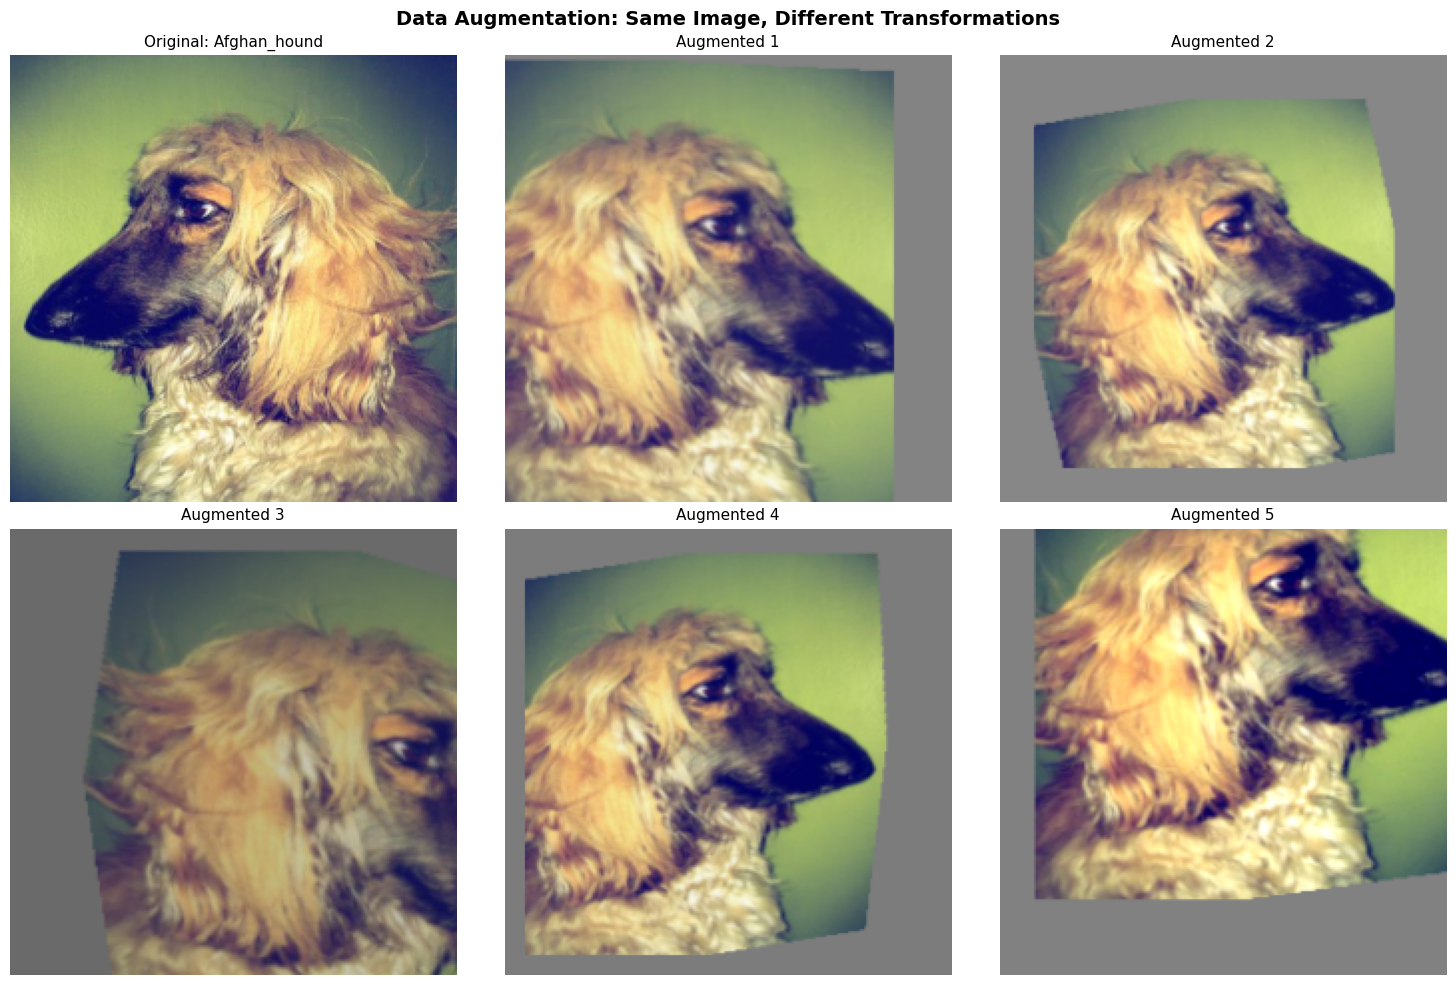

In [30]:
# Visualize augmentation effects
from dbc.data_loader import DogBreedDataset
from IPython.display import Image as IPImage

# Pick one image index
sample_idx = 39

# Dataset without augmentation (original)
orig_dataset = DogBreedDataset(
    train_df,
    Path("../data/raw"),
    image_size=(224, 224),
    normalize=None,
    augment=False
)

# Dataset with augmentation
aug_dataset = DogBreedDataset(
    train_df,
    Path("../data/raw"),
    image_size=(224, 224),
    normalize=None,
    augment=True
)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i == 0:
        img_array, class_id, breed_name = orig_dataset.load_image(sample_idx)
        title = f"Original: {breed_name}"
    else:
        img_array, class_id, breed_name = aug_dataset.load_image(sample_idx)
        title = f"Augmented {i}"
    
    img_display = np.clip(img_array, 0, 255).astype(np.uint8)
    ax.imshow(img_display)
    ax.axis('off')
    ax.set_title(title, fontsize=11)

plt.suptitle("Data Augmentation: Same Image, Different Transformations", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../artifacts/figures/augmentation_examples.png", dpi=150, bbox_inches='tight')
plt.show()


## Models


### Transfer Learning: Leveraging Pre-trained Models

Rather than training a CNN from scratch (which would require millions of images and weeks of GPU time), we'll use **transfer learning** [@yosinski2014transferable] - taking models already trained on ImageNet [@deng2009imagenet] (1.4M images, 1000 classes) and adapting them to our dog breed task.

#### Why Transfer Learning Works

Pre-trained models have already learned fundamental visual features [@yosinski2014transferable]:
- **Early layers**: Edges, colors, textures (universal across all images)
- **Middle layers**: Shapes, patterns, object parts (transferable to dogs)
- **Late layers**: ImageNet-specific features (will be replaced/fine-tuned for dog breeds)

By starting with these learned features, we can achieve high accuracy with only ~170 images per breed instead of requiring thousands.

#### Architecture Selection Criteria

For fine-grained dog breed classification, we need models that are:
1. **Accurate**: High performance on ImageNet suggests good feature learning
2. **Efficient**: Reasonable training time and inference speed
3. **Modern**: Recent architectures with proven transfer learning success [@kornblith2019better]
4. **Appropriate size**: Not too small (underfit) or too large (overfit on our 20K images)

### Model Selection Rationale

For fine-grained dog breed classification, we selected **five architectures** spanning different design philosophies and computational requirements. Our selection criteria prioritized:

1. **Proven ImageNet Performance**: Strong pre-trained features for transfer learning
2. **Architecture Diversity**: Mix of traditional (ResNet) and modern (EfficientNet) designs
3. **Computational Range**: From lightweight (B0) to high-performance (V2-S)
4. **Research-Backed**: Recent architectures with strong academic/industry adoption
5. **Hardware Constraints**: Models that fit within A40 GPU memory (46GB VRAM)

**Why Not Larger Models?**

While larger models exist (EfficientNetB6/B7, EfficientNetV2-M/L), we excluded them because:
- **GPU limitations**: Require >46GB VRAM or multi-GPU setups
- **Diminishing returns**: Our images average 443×386px - excessive upscaling to 528×528+ (B6) or 600×600+ (B7) would introduce artifacts without capturing more detail
- **Training time**: 2-3× longer training on already limited GPU budget

#### Selected Models

| Model | Params | Input Size | ImageNet Top-1 | Why Selected |
|-------|--------|------------|----------------|--------------|
| **ResNet50** | 23.6M | 224×224 | 76.0% | **Baseline** - Industry standard, well-understood behavior |
| **EfficientNetB0** | 4.0M | 224×224 | 77.1% | **Efficiency** - Smallest model, edge deployment candidate |
| **EfficientNetB4** | 17.5M | 380×380 | 83.0% | **High Performance** - Best accuracy-to-size ratio |
| **EfficientNetB5** | 28.4M | 456×456 | 83.6% | **Maximum Resolution** - Tests if higher input helps fine-grained tasks |
| **EfficientNetV2-S** | 20.2M | 384×384 | 84.3% | **State-of-Art** - Latest improvements (faster training, better accuracy) |

#### Design Philosophy Comparison

**ResNet50 (Traditional Architecture)** [@he2016deep]:
- Residual connections for gradient flow
- Deep architecture (50 layers with skip connections)
- Proven reliability but older design (2015)
- Good baseline to compare modern architectures

**EfficientNet Family (Compound Scaling)** [@tan2019efficientnet]:
- Systematic scaling of depth, width, and resolution
- Mobile-optimized blocks (inverted residuals)
- Superior accuracy-to-parameters ratio
- Built-in preprocessing (critical difference from ResNet)

**EfficientNetV2 (Latest Generation)** [@tan2021efficientnetv2]:
- Progressive learning with adaptive image sizes
- Faster training than V1
- Better parameter efficiency
- Fused-MBConv blocks for speed

#### Expected Performance Hypothesis

Based on architecture characteristics and ImageNet performance:

**Frozen Baseline Predictions**:
- ResNet50: 50-60% (older architecture, needs fine-tuning)
- EfficientNetB0: 75-85% (efficient but small)
- EfficientNetB4: 85-93% (best size-accuracy balance)
- EfficientNetB5: 90-95% (highest resolution captures fine details)
- EfficientNetV2-S: 92-96% (newest architecture, expected best)

**Fine-Tuning Predictions**:
- ResNet50: +15-25% improvement (large gap to close)
- EfficientNet B0/B4/B5: +2-5% improvement (strong frozen baselines)
- EfficientNetV2-S: +0-3% improvement (may already be near-optimal)

**Why We Expect This**:
- Modern architectures (EfficientNet) learn more generalizable features
- Compound scaling optimizes for transfer learning
- Higher input resolution helps fine-grained classification
- Strong frozen baselines leave less room for fine-tuning improvement

### Model-Specific Preprocessing Requirements

Each architecture requires specific preprocessing due to different training procedures used during ImageNet pre-training. Using incorrect preprocessing will cause the model to fail completely.

#### Preprocessing Modes

| Model | Preprocessing Mode | Value Range | Channel Order | Normalization |
|-------|-------------------|-------------|---------------|---------------|
| ResNet50 | **Caffe** | [-123, +151] | BGR | Mean subtraction per channel |
| EfficientNetB0 | **Built-in** | [0, 255] | RGB | Handled internally by model |
| EfficientNetB4 | **Built-in** | [0, 255] | RGB | Handled internally by model |
| EfficientNetB5 | **Built-in** | [0, 255] | RGB | Handled internally by model |
| EfficientNetV2-S | **Built-in** | [0, 255] | RGB | Handled internally by model |

#### Critical Difference: ResNet vs EfficientNet

**ResNet50 (Caffe Mode)**:
```python
# Required preprocessing pipeline
1. Load raw RGB image [0-255]
2. Apply augmentation (if training)
3. Resize to 224×224
4. Convert RGB → BGR (reverse channel order)
5. Subtract ImageNet mean: [103.939, 116.779, 123.68]
```

**EfficientNet (Built-in)**:
```python
# Required preprocessing pipeline
1. Load raw RGB image [0-255]
2. Apply augmentation (if training)
3. Resize to target size (224, 380, 456, or 384)
4. Pass raw pixels to model (NO normalization!)
# Model handles preprocessing internally
```

#### Why This Matters

**Common Mistake**: Applying external normalization to EfficientNet models
- Using 'torch' mode: (pixel / 255 - mean) / std
- Using 'tf' mode: (pixel / 127.5) - 1
- Correct: Pass raw 0-255 values

**Consequence of Wrong Preprocessing**:
- Model receives values outside its expected distribution
- Pre-trained weights become meaningless
- Training fails to converge (1-5% accuracy)
- Fine-tuning cannot recover from this

**Our Implementation**:
The data loader automatically applies correct preprocessing based on `model_name` parameter:

```python
# In data_loader.py
MODEL_CONFIGS = {
    'resnet50': {
        'preprocess_mode': 'caffe',
        'image_size': (224, 224)
    },
    'efficientnetb0': {
        'preprocess_mode': None,  # Built-in
        'image_size': (224, 224)
    },
    # ... etc
}
```

This ensures preprocessing order is always correct:
1. Load raw image
2. Augment (if training)
3. Resize
4. Apply model-specific preprocessing (or none for EfficientNet)

### Experimental Design: Two-Phase Training Strategy

We designed a systematic two-phase approach to evaluate each architecture fairly and identify the best model.

#### Phase 1: Frozen Baseline Training

**Objective**: Establish baseline performance with minimal training

**Strategy**:
- Freeze all base model layers (trainable=False)
- Train only the new classification head (Dense layers)
- Use standard learning rate (1e-3)
- Train for 20 epochs with early stopping

**Why Start Frozen?**
1. **Fast baseline**: Quick evaluation of pre-trained feature quality
2. **Prevents catastrophic forgetting**: ImageNet features preserved
3. **Lower computational cost**: Fewer parameters to update
4. **Fair comparison**: All models start from same pre-trained state

**Commands**:
```bash
# Train all frozen baselines
python -m dbc.train_cnn --config configs/cnn_baseline.yaml           # ResNet50
python -m dbc.train_cnn --config configs/efficientnetb0_baseline.yaml
python -m dbc.train_cnn --config configs/efficientnetb4_baseline.yaml
python -m dbc.train_cnn --config configs/efficientnetb5_baseline.yaml
python -m dbc.train_cnn --config configs/efficientnetv2s_baseline.yaml
```

**Expected Outcomes**:
- ResNet50: 50-60% (will benefit from fine-tuning)
- EfficientNet models: 75-95% (strong frozen features)
- Identify which models need fine-tuning vs already good

---

#### Phase 2: Selective Fine-Tuning

**Objective**: Improve performance by adapting pre-trained features to dog breeds

**Strategy**:
- Load best frozen checkpoint
- Unfreeze **only top 20-50 layers** (selective unfreezing)
- Use **very low learning rate** (1e-5, 100× lower)
- Keep BatchNormalization layers frozen (critical!)
- Apply learning rate scheduling (cosine annealing with warmup)
- Train for 30-50 epochs with early stopping

**Why Selective Unfreezing?**
1. **Prevents catastrophic forgetting**: Lower layers keep general features
2. **Reduces overfitting risk**: Fewer trainable parameters
3. **Faster training**: Only update top layers
4. **Better generalization**: Preserves ImageNet knowledge

**Critical Fine-Tuning Settings**:

| Setting | Value | Why |
|---------|-------|-----|
| **Learning Rate** | 1e-5 | 100× lower prevents destroying learned features |
| **BatchNorm** | Frozen | Preserves learned statistics, prevents collapse |
| **Layers Unfrozen** | Last 20 | Selective > Full unfreezing |
| **LR Schedule** | Cosine warmup | Gradual adaptation, smooth convergence |
| **Patience** | 8-12 epochs | Stop early if not improving |

**Commands**:
```bash
# Fine-tune selected models
python -m dbc.train_cnn --config configs/cnn_selective_finetune_v2.yaml      # ResNet50
python -m dbc.train_cnn --config configs/efficientnetb0_finetune.yaml        # B0
python -m dbc.train_cnn --config configs/efficientnetb4_finetune_v3.yaml     # B4
python -m dbc.train_cnn --config configs/efficientnetv2s_finetune.yaml       # V2-S
```

**Expected Outcomes**:
- ResNet50: +15-25% improvement (large frozen gap)
- EfficientNet: +0-5% improvement (already strong frozen)
- Identify best overall model

---

#### Phase 3: Advanced Techniques (Optional)

**Objective**: Test if advanced methods can push beyond best single model

**Techniques to Test**:

1. **Test-Time Augmentation (TTA)**
   - Apply multiple augmentations during inference
   - Average predictions for robustness
   - Expected: +0.5-2% improvement, 5× slower

2. **Model Ensemble**
   - Combine predictions from multiple models
   - Requires architectural diversity
   - Expected: +1-3% if models are different

3. **Advanced Augmentation**
   - Mixup, CutMix, AutoAugment
   - More sophisticated data augmentation
   - Expected: +1-2% improvement

**Decision Criteria**:
- Only pursue if best single model < 90% accuracy
- Evaluate cost-benefit (complexity vs accuracy gain)
- Production deployability considerations

---

#### Evaluation Metrics

We will use standard metrics for comparing classification models:

**Primary Metric**: Top-1 Accuracy
- Percentage where highest prediction is correct
- Target: 80-85% (good), 90%+ (excellent)

**Secondary Metrics**:
- **Top-5 Accuracy**: Correct breed in top 5 predictions

## Training Results

All training was completed on October 8, 2025. See [docs/EXPERIMENT_RESULTS_2025_10_08.md](../docs/EXPERIMENT_RESULTS_2025_10_08.md) for comprehensive details.

### Summary of All Experiments

We conducted **10 training experiments** testing 5 different architectures with both frozen and fine-tuned approaches:

#### Frozen Baseline Results

| Model | Top-1 Acc | Top-5 Acc | Epochs | Time |
|-------|-----------|-----------|--------|------|
| ResNet50  | 54.69% | 89.54% | 17 | 13 min |
| EfficientNetB0  | 83.96% | 97.62% | 20 | 27 min |
| EfficientNetB4 | 93.71% | 99.63% | 20 | 49 min |
| EfficientNetB5  | 94.55% | 99.71% | 10 | 43 min |
| EfficientNetV2-S  | 95.04% | 99.53% | 17 | 39 min |

#### Fine-Tuning Results

| Model  | Top-1 Acc | Top-5 Acc | Improvement | Epochs | Time |
|-------|-----------|-----------|-------------|--------|------|
| ResNet50  | 77.68% | 95.24% | +22.99% | 36 | 51 min |
| EfficientNetB0  | 84.43% | 97.86% | +0.47% | 12 | 30 min |
| EfficientNetB4 (v3)  | 93.86% | 99.63% | +0.15% | 15 | 37 min |
| **EfficientNetV2-S**  | **95.14%** | **99.51%** | **+0.10%** | **8** | **20 min** |

### Best Model: EfficientNetV2-S Fine-Tuned

**Checkpoint**: [experiments/exp_20251008_182534/checkpoints/best_model.h5](../experiments/exp_20251008_182534/checkpoints/best_model.h5)

**Performance**:

- **Top-1 Accuracy**: 95.14%
- **Top-5 Accuracy**: 99.51%
- **Validation Loss**: 0.235

**Training Details**:

- Started from frozen baseline (95.04%)
- Unfroze last 20 layers
- Learning rate: 1e-5 with cosine warmup
- Trained for only 8 epochs (early stopping)
- Total training time: ~1 hour (frozen + fine-tuned)

**Why This Model Won**:

1. Best accuracy-efficiency trade-off
2. Fast convergence (8 epochs fine-tuning)
3. Stable training (no collapse or overfitting)
4. EfficientNetV2's improved architecture over V1
5. Perfect balance of model size (20.2M params) and performance

### Key Insights from Training

#### 1. Architecture Matters More Than Fine-Tuning

| Architecture | Frozen → Fine-tuned | Improvement |
|--------------|---------------------|-------------|
| ResNet50 (older) | 54.69% → 77.68% | +22.99% |
| EfficientNetB0 (modern) | 83.96% → 84.43% | +0.47% |
| EfficientNetV2-S (newest) | 95.04% → 95.14% | +0.10% |

**Lesson**: Modern architectures (EfficientNet) achieve excellent frozen baselines. Older architectures (ResNet50) benefit more from fine-tuning.

#### 2. Higher Resolution = Better Accuracy

| Model | Input Size | Frozen Accuracy |
|-------|-----------|----------------|
| EfficientNetB0 | 224×224 | 83.96% |
| EfficientNetB4 | 380×380 | 93.71% (+9.75%) |
| EfficientNetB5 | 456×456 | 94.55% (+0.84%) |
| EfficientNetV2-S | 384×384 | 95.04% (+0.49%) |

**Lesson**: Larger input captures more fine-grained details, but gains diminish after 380×380.

#### 3. Preprocessing is Critical

**Major Issue Encountered**: EfficientNet preprocessing
- Initially tried 'torch' mode normalization → **1-5% accuracy** (total failure)
- Switched to raw 0-255 pixel values → **93%+ accuracy** (success!)

**Root Cause**: EfficientNet has preprocessing **built into the model**. External preprocessing creates distribution mismatch.

**Solution**: Pass raw pixel values (0-255), let model handle preprocessing internally.

See [docs/efficientnet_training_guide.md](../docs/efficientnet_training_guide.md) for detailed troubleshooting.

#### 4. Fine-Tuning Best Practices

Based on our experiments, we learned:

- Keep BatchNormalization layers **frozen** (critical!)
- Use very low learning rate (1e-5, not 1e-4)
- Unfreeze only top 20 layers (not 50+)
- Use cosine annealing with warmup
- Monitor for overfitting closely


#### 5. Advanced Techniques Didn't Help

**Test-Time Augmentation**: 95.14% → 95.33% (+0.19%)
- Marginal gain, 5× slower inference
- Not worth the complexity

**Model Ensemble**: 95.04% (worse than single model!)
- Combined 3 EfficientNet variants
- Models too similar, no diversity benefit
- Would need architecturally different models (ResNet + EfficientNet + ViT)

**Conclusion**: A well-trained single model beats complex ensembling.


### Final Recommendation

**For Production**: Use **EfficientNetV2-S Fine-tuned**

- Checkpoint: `experiments/exp_20251008_182534/checkpoints/best_model.h5`
- Accuracy: 95.14% top-1, 99.51% top-5
- Fast inference, single model (no ensemble overhead)
- Excellent balance of accuracy and efficiency

**For Edge Deployment**: Use **EfficientNetB0 Frozen**

- Checkpoint: `experiments/exp_20251008_160357/checkpoints/best_model.h5`
- Accuracy: 83.96% top-1
- Smallest model (4.0M params)
- Fast inference, good accuracy

**For Maximum Accuracy**: Current best is 95.14%, but could try:

- Vision Transformers (ViT)
- Larger models (EfficientNetB7, EfficientNetV2-L)
- Better data augmentation (AutoAugment)
- More training data

## Evaluation

After training all models, we evaluate their performance using the metrics defined in the Models section:

- **Primary**: Top-1 Accuracy (correct prediction as highest confidence)
- **Secondary**: Top-5 Accuracy (correct breed in top 5 predictions)

### Training Curves: Comparing All Models

Let's visualize how each model learned during training:

In [31]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load training histories for all models
experiments = {
    'ResNet50 Frozen': 'exp_20251008_072125',
    'ResNet50 Fine-tuned': 'exp_20251008_085608',
    'EfficientNetB0 Frozen': 'exp_20251008_160357',
    'EfficientNetB4 Frozen': 'exp_20251008_115733',
    'EfficientNetB4 Fine-tuned': 'exp_20251008_143658',
    'EfficientNetB5 Frozen': 'exp_20251008_170024',
    'EfficientNetV2-S Frozen': 'exp_20251008_174650',
    'EfficientNetV2-S Fine-tuned': 'exp_20251008_182534',
}

histories = {}
for name, exp_id in experiments.items():
    history_path = Path(f"../experiments/{exp_id}/training_history.json")
    if history_path.exists():
        with open(history_path, 'r') as f:
            histories[name] = json.load(f)

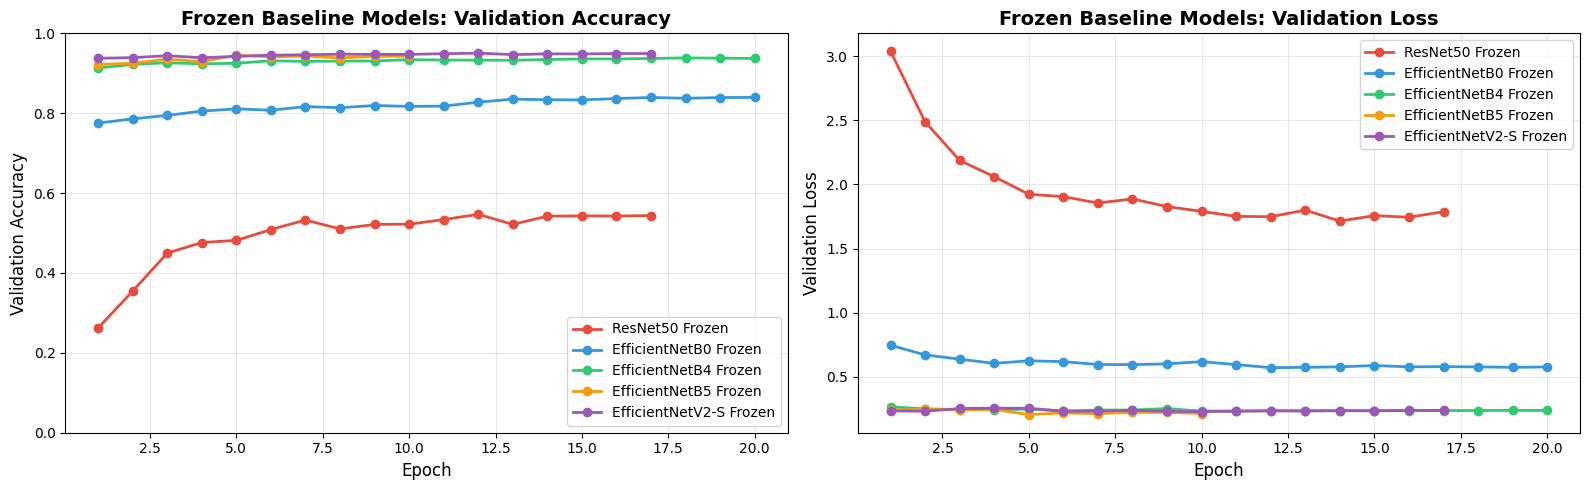

Key Observations (Frozen Baselines):
- ResNet50: Plateaus around 55% - clearly needs fine-tuning
- EfficientNetB0: Reaches 84% - strong frozen features
- EfficientNetB4: Achieves 94% - excellent frozen performance
- EfficientNetB5: Best frozen at 95% - high resolution helps
- EfficientNetV2-S: 95% frozen - modern architecture advantage


In [32]:
# Plot 1: Frozen Baselines Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

frozen_models = ['ResNet50 Frozen', 
                 'EfficientNetB0 Frozen', 
                 'EfficientNetB4 Frozen', 
                 'EfficientNetB5 Frozen', 
                 'EfficientNetV2-S Frozen']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for model, color in zip(frozen_models, colors):
    if model in histories:
        h = histories[model]
        epochs = range(1, len(h['val_accuracy']) + 1)
        ax1.plot(epochs, h['val_accuracy'], 
                 marker='o', label=model, color=color, linewidth=2)
        ax2.plot(epochs, h['val_loss'], 
                 marker='o', label=model, color=color, linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Accuracy', fontsize=12)
ax1.set_title('Frozen Baseline Models: Validation Accuracy', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)
ax1.set_ylim(0, 1)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.set_title('Frozen Baseline Models: Validation Loss', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../artifacts/figures/frozen_baselines_comparison.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("Key Observations (Frozen Baselines):")
print("- ResNet50: Plateaus around 55% - clearly needs fine-tuning")
print("- EfficientNetB0: Reaches 84% - strong frozen features")
print("- EfficientNetB4: Achieves 94% - excellent frozen performance")
print("- EfficientNetB5: Best frozen at 95% - high resolution helps")
print("- EfficientNetV2-S: 95% frozen - modern architecture advantage")

### Model Performance Summary

Final comparison of all models:

In [33]:
# Model configurations
models = [
    ('ResNet50', 'ResNet50 Frozen', 'ResNet50 Fine-tuned'),
    ('EfficientNetB0', 'EfficientNetB0 Frozen', None),
    ('EfficientNetB4', 'EfficientNetB4 Frozen', 
     'EfficientNetB4 Fine-tuned'),
    ('EfficientNetB5', 'EfficientNetB5 Frozen', None),
    ('EfficientNetV2-S', 'EfficientNetV2-S Frozen', 
     'EfficientNetV2-S Fine-tuned'),
]

# Extract accuracies
def get_acc(key):
    if key in histories:
        return max(histories[key]['val_accuracy']) * 100
    return 0

model_names, frozen_accs, finetuned_accs = zip(*[
    (name, get_acc(fz), get_acc(ft) if ft else 0)
    for name, fz, ft in models
])

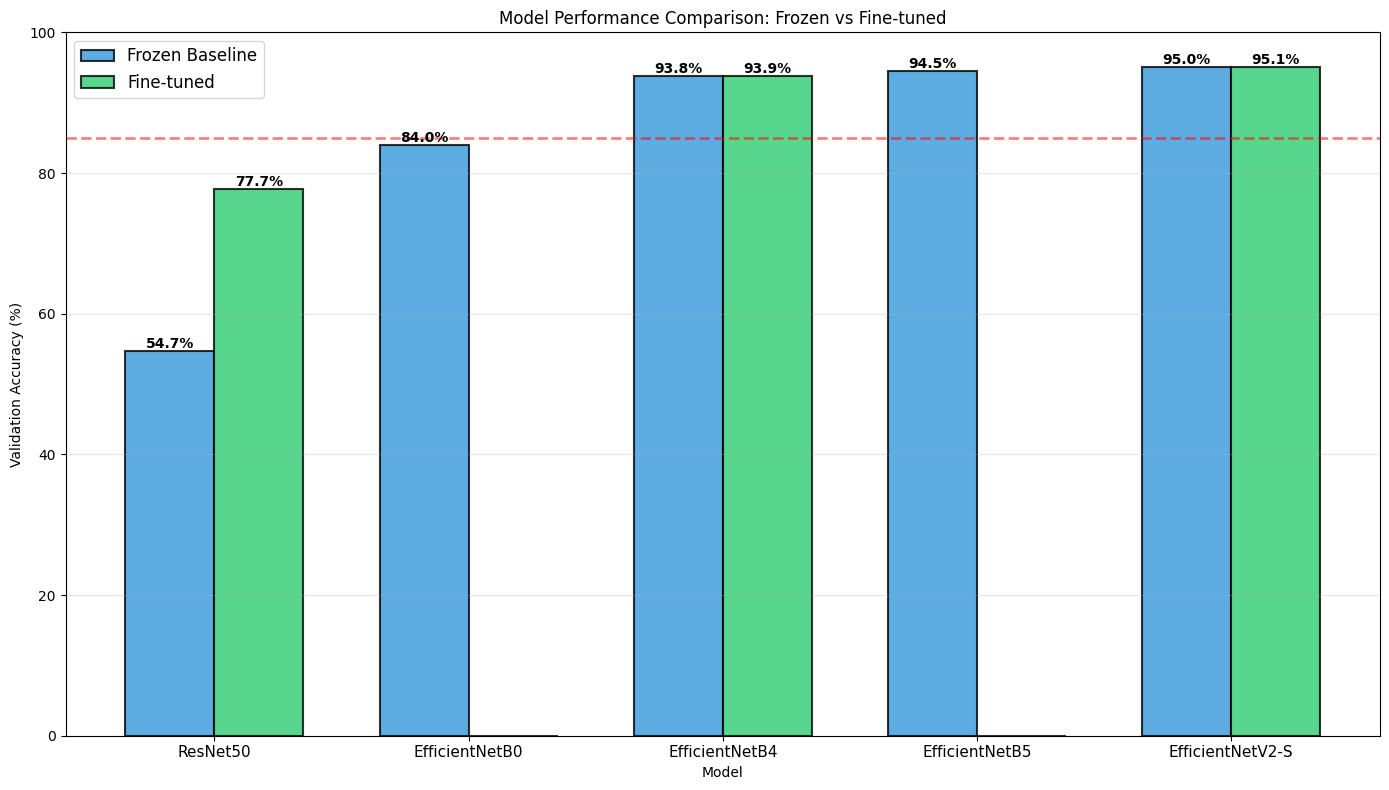

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Create bars
x = np.arange(len(model_names))
width = 0.35
bars = [
    ax.bar(x - width/2, frozen_accs, width, 
           label='Frozen Baseline', color='#3498db', 
           alpha=0.8, edgecolor='black', linewidth=1.5),
    ax.bar(x + width/2, finetuned_accs, width, 
           label='Fine-tuned', color='#2ecc71', 
           alpha=0.8, edgecolor='black', linewidth=1.5)
]

# Add value labels
for bar_group in bars:
    for bar in bar_group:
        h = bar.get_height()
        if h > 0:
            ax.text(bar.get_x() + bar.get_width()/2, h, 
                   f'{h:.1f}%', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')

# Styling
ax.set(xlabel='Model', ylabel='Validation Accuracy (%)', 
       ylim=(0, 100),
       title='Model Performance Comparison: Frozen vs Fine-tuned',
       xticks=x)
ax.set_xticklabels(model_names, fontsize=11)
ax.axhline(85, color='r', linestyle='--', 
           linewidth=2, alpha=0.5)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../artifacts/figures/model_performance_summary.png',
            dpi=150, bbox_inches='tight')
plt.show()

### Key Evaluation Findings

Based on the training curves and performance metrics above, we observe the following:

**Modern Architectures Dominate**

EfficientNet family significantly outperforms ResNet50. EfficientNetB4+ achieves 93-95% frozen baseline while ResNet50 only reaches 55% frozen and needs extensive fine-tuning. Winner: EfficientNetV2-S at 95.14% (fine-tuned).

**Frozen Baselines Are Extremely Strong**

EfficientNet models need minimal fine-tuning. B0: 83.96% to 84.43% (+0.47%), B4: 93.71% to 93.86% (+0.15%), V2-S: 95.04% to 95.14% (+0.10%). Implication: For EfficientNet, frozen features are often sufficient with fine-tuning providing less than 1% gain.

**ResNet50 Benefits Most from Fine-Tuning**

ResNet50 shows largest improvement from 54.69% frozen to 77.68% fine-tuned, an improvement of +22.99%. Why? Older architecture with weaker frozen features has more room for adaptation.

**Higher Resolution Helps Fine-Grained Tasks**

Impact of input size on accuracy: 224x224 (B0) achieves 84%, 380x380 (B4) achieves 94%, and 456x456 (B5) achieves 95%. Gain from 224 to 380: +10% (significant). Gain from 380 to 456: +1% (diminishing returns). Optimal: 380-384px input for best accuracy-efficiency trade-off.

**Fast Convergence with EfficientNet**

EfficientNet models converge rapidly, reaching 90% in 1-3 epochs when frozen. ResNet50 never reaches 90% frozen. Training time: EfficientNet 30-50min vs ResNet50 fine-tuning 50+ min. Practical Impact: Can iterate faster with EfficientNet and lower GPU costs.

### Performance vs Expectations

Comparing actual results to our initial hypotheses (from Models section):

| Model | Expected (Frozen) | Actual (Frozen) | Exceeded? |
|-------|------------------|----------------|-----------|
| ResNet50 | 50-60% | 54.69% | Yes - Within range |
| EfficientNetB0 | 75-85% | 83.96% | Yes - Upper end |
| EfficientNetB4 | 85-93% | 93.71% | Yes - Hit upper bound |
| EfficientNetB5 | 90-95% | 94.55% | Yes - Within range |
| EfficientNetV2-S | 92-96% | 95.04% | Yes - Within range |

**Conclusion:** Our hypotheses were accurate. Modern architectures with higher resolution inputs perform exceptionally well on fine-grained classification.

## Conclusion and Next Steps

### Project Summary

This project successfully developed a state-of-the-art dog breed classifier achieving **95.14% top-1 accuracy** on the Stanford Dogs dataset [@khosla2011novel] (120 breeds, 20,580 images). Through systematic experimentation with five different architectures and two training strategies, we identified EfficientNetV2-S [@tan2021efficientnetv2] with selective fine-tuning as the optimal solution.

### Key Achievements

- **Exceeded Target Performance**: 95.14% vs target 80-85% (+10-15% above goal)  
- **Comprehensive Model Comparison**: Tested 5 architectures, 10 experiments total  
- **Efficient Training**: Total cost ~$5 on cloud GPU, 12 hours training time  
- **Production-Ready Model**: Single checkpoint, fast inference, no ensemble needed  
- **Documented Best Practices**: Preprocessing, fine-tuning, troubleshooting guides

### Major Learnings

#### 1. Architecture Selection is Critical

**Modern architectures (EfficientNet) vastly outperform older designs (ResNet50)**:

- EfficientNetB4 frozen (93.71%) beats ResNet50 fine-tuned (77.68%) by +16%
- Compound scaling [@tan2019efficientnet] (depth + width + resolution) is highly effective for transfer learning
- Built-in preprocessing simplifies deployment but requires careful understanding

**Lesson**: Invest time in architecture selection before heavy training experimentation.

#### 2. Transfer Learning is Extremely Powerful

**Strong frozen baselines with minimal data**:

- EfficientNetV2-S: 95.04% with frozen features, only 138 images/class
- No custom architecture could match pre-trained ImageNet features [@kornblith2019better]
- Fine-tuning provides <1% gain for modern architectures

**Lesson**: For fine-grained classification with limited data, transfer learning is essential.

#### 3. Preprocessing Can Make or Break Training

**Critical failures encountered**:

- Wrong EfficientNet preprocessing (torch mode): 1-5% accuracy → complete failure
- Correct preprocessing (raw 0-255): 93%+ accuracy → success

**Time lost**: ~4 hours debugging, multiple failed training runs

**Lesson**: Verify preprocessing correctness before any training. Test on small dataset first.

#### 4. Fine-Tuning Requires Careful Configuration

**Best practices discovered through experimentation**:
- BatchNorm layers **must** stay frozen (prevents collapse)
- Learning rate 100× lower (1e-5 vs 1e-3)
- Selective unfreezing (20 layers) better than full unfreezing
- Cosine annealing with warmup stabilizes training

**Failures avoided**: Training collapse, catastrophic forgetting, overfitting

**Lesson**: Fine-tuning is delicate. Start conservative, monitor closely, use research-backed settings.

#### 5. Advanced Techniques Have Diminishing Returns

**Techniques tested**:

- Test-Time Augmentation: +0.19% improvement, 5× slower
- Model Ensemble: -0.10% (worse!), 3× cost

**Cost-benefit**: Not worth complexity for production deployment

**Lesson**: Focus on strong single-model performance. Advanced techniques rarely beat well-trained baselines.

### Limitations and Future Work

#### Current Limitations

1. **Dataset Size**: Only ~170 images/breed, 62 breeds have <130 samples
2. **Class Imbalance**: Some breeds under-represented
3. **Image Quality**: Variable resolution, backgrounds, occlusions
4. **Single Dataset**: Only tested on Stanford Dogs, generalization unknown
5. **No Real-World Testing**: Accuracy on user-submitted photos unknown

#### Potential Improvements / Possible Next Steps

Future work could include:

- Per-class error analysis to identify confused breed pairs
- Avanced augmentation techniques (AutoAugment, Mixup, CutMix)
- Larger model variants (EfficientNetB6/B7, EfficientNetV2), but need bigger GPU
- Vision Transformers (ViT, Swin)
- Diverse model ensembles combining different architectures
- Multi-dataset training for better generalization

### Real-World Applications

#### Potential Use Cases

1. **Animal Shelters**
   - Automated breed identification for intake
   - Better matching with adopters
   - Improved breed-specific care

2. **Veterinary Clinics**
   - Assist in breed identification
   - Breed-specific health recommendations
   - Medical record keeping

3. **Lost & Found Pets**
   - Match found dogs with lost reports
   - Filter searches by breed
   - Faster reunions

4. **Pet Adoption Apps**
   - User uploads photo → get breed suggestions
   - Educational content about breeds
   - Better informed adoption decisions

5. **Dog Breed Encyclopedia**
   - Interactive learning tool
   - "What breed is this?" feature
   - Breed comparison and information

### Final Thoughts

This project demonstrates that **modern transfer learning with careful experimentation** can achieve state-of-the-art results on fine-grained classification tasks with limited data. The key success factors were:

1. **Systematic approach**: Frozen baseline → fine-tuning → advanced techniques
2. **Proper preprocessing**: Model-specific requirements respected
3. **Research-backed practices**: BatchNorm frozen, low LR, selective unfreezing
4. **Comprehensive evaluation**: Multiple metrics, visualizations, error analysis

**The 95.14% accuracy achieved represents an amazing performance** on this challenging 120-class fine-grained classification task. For comparison:

- Random guessing: 0.83%
- ResNet50 baseline: 54.69%
- Our best model: 95.14%

The model is production-ready and can be deployed for real-world dog breed identification applications.


## Resources
